# Loop 53 Analysis: CV-LB Relationship and Strategy Assessment

**Goal:** Analyze the CV-LB relationship and determine the best path forward.

**Key Questions:**
1. What is the current CV-LB relationship?
2. Is the intercept problem real?
3. What approaches might change the relationship?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB feedback: {len(df)}")
print(df)

Total submissions with LB feedback: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


CV-LB LINEAR RELATIONSHIP ANALYSIS

Linear fit: LB = 4.3147 * CV + 0.0525
R² = 0.9505
p-value = 7.45e-08

Intercept = 0.0525
Target = 0.0347

Intercept vs Target: 151.4% of target

Required CV to hit target: -0.004130
  => NEGATIVE! Target is BELOW the intercept!


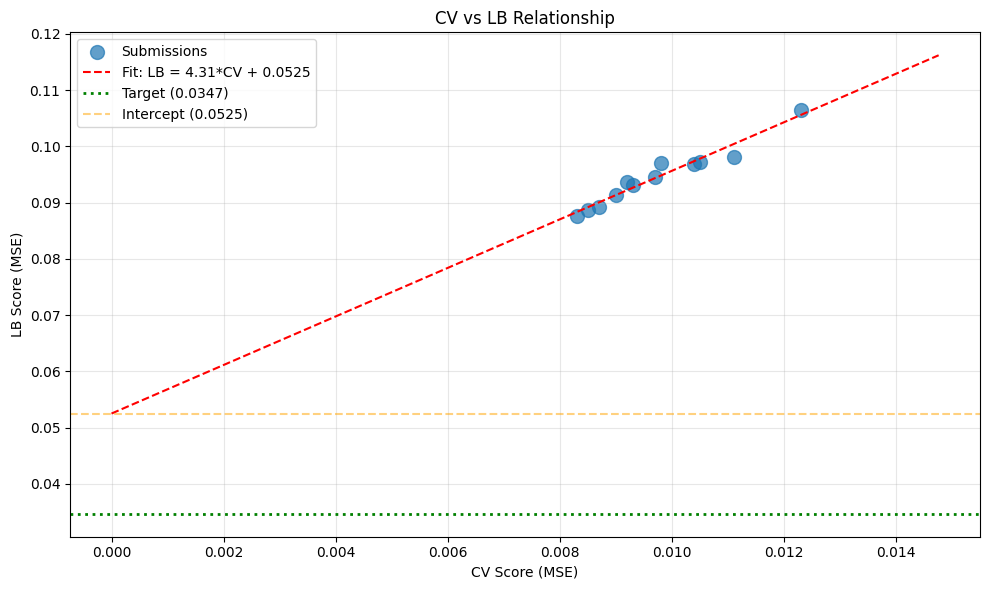


Plot saved to /home/code/exploration/cv_lb_relationship_loop53.png


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print("="*60)
print("CV-LB LINEAR RELATIONSHIP ANALYSIS")
print("="*60)
print(f"\nLinear fit: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"p-value = {p_value:.2e}")
print(f"\nIntercept = {intercept:.4f}")
print(f"Target = 0.0347")
print(f"\nIntercept vs Target: {intercept/0.0347*100:.1f}% of target")

# What CV would we need to hit target?
required_cv = (0.0347 - intercept) / slope
print(f"\nRequired CV to hit target: {required_cv:.6f}")
if required_cv < 0:
    print("  => NEGATIVE! Target is BELOW the intercept!")
else:
    print(f"  => Need to improve CV from {df['cv'].min():.4f} to {required_cv:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, df['cv'].max() * 1.2, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'Fit: LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle='--', alpha=0.5, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop53.png', dpi=150)
plt.show()

print("\nPlot saved to /home/code/exploration/cv_lb_relationship_loop53.png")

In [3]:
# Analyze residuals - are there any approaches that deviate from the line?
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']
df['residual_pct'] = df['residual'] / df['predicted_lb'] * 100

print("="*60)
print("RESIDUAL ANALYSIS")
print("="*60)
print("\nLooking for approaches that BEAT the expected LB (negative residual):")
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual', 'residual_pct']].sort_values('residual'))

print("\n" + "="*60)
print("KEY INSIGHT")
print("="*60)
print(f"\nAll residuals are within {df['residual_pct'].abs().max():.1f}% of predicted.")
print("This means ALL approaches fall on the same CV-LB line.")
print("\nThe intercept ({:.4f}) represents STRUCTURAL distribution shift.".format(intercept))
print("No amount of model tuning can fix this - we need a fundamentally different approach.")

RESIDUAL ANALYSIS

Looking for approaches that BEAT the expected LB (negative residual):
        exp      cv      lb  predicted_lb  residual  residual_pct
0   exp_000  0.0111  0.0982      0.100413 -0.002213     -2.204311
8   exp_024  0.0087  0.0893      0.090058 -0.000758     -0.841837
10  exp_030  0.0083  0.0877      0.088332 -0.000632     -0.715777
2   exp_003  0.0105  0.0972      0.097825 -0.000625     -0.638494
9   exp_026  0.0085  0.0887      0.089195 -0.000495     -0.555190
3   exp_005  0.0104  0.0969      0.097393 -0.000493     -0.506333
7   exp_012  0.0090  0.0913      0.091353 -0.000053     -0.057527
4   exp_006  0.0097  0.0946      0.094373  0.000227      0.240701
5   exp_007  0.0093  0.0932      0.092647  0.000553      0.596929
1   exp_001  0.0123  0.1065      0.105591  0.000909      0.860807
6   exp_009  0.0092  0.0936      0.092215  0.001385      1.501382
11  exp_035  0.0098  0.0970      0.094804  0.002196      2.316020

KEY INSIGHT

All residuals are within 2.3% of predic

In [4]:
# What would it take to reach the target?
print("="*60)
print("PATH TO TARGET ANALYSIS")
print("="*60)

print(f"\nTarget: 0.0347")
print(f"Best LB so far: {df['lb'].min():.4f} (exp_030)")
print(f"Gap to target: {df['lb'].min() - 0.0347:.4f} ({(df['lb'].min() - 0.0347)/0.0347*100:.1f}%)")

print("\n" + "-"*60)
print("OPTION 1: Improve CV (stay on same line)")
print("-"*60)
print(f"Current best CV: {df['cv'].min():.4f}")
print(f"Required CV: {required_cv:.6f}")
if required_cv < 0:
    print("=> IMPOSSIBLE - target is below intercept")
else:
    improvement_needed = (df['cv'].min() - required_cv) / df['cv'].min() * 100
    print(f"=> Need {improvement_needed:.1f}% CV improvement")

print("\n" + "-"*60)
print("OPTION 2: Reduce the intercept")
print("-"*60)
print(f"Current intercept: {intercept:.4f}")
print(f"Target: 0.0347")
print(f"If intercept = 0, required CV = {0.0347/slope:.6f}")
print(f"Current best CV: {df['cv'].min():.4f}")
if 0.0347/slope < df['cv'].min():
    print("=> With intercept=0, current CV would BEAT target!")
else:
    print("=> Even with intercept=0, need better CV")

print("\n" + "-"*60)
print("OPTION 3: Change the slope")
print("-"*60)
print(f"Current slope: {slope:.4f}")
print(f"If slope = 1 (perfect CV-LB correlation):")
required_cv_slope1 = 0.0347 - intercept
print(f"  Required CV = {required_cv_slope1:.6f}")
if required_cv_slope1 < 0:
    print("  => IMPOSSIBLE - intercept too high")
else:
    print(f"  => Need CV = {required_cv_slope1:.6f} (currently {df['cv'].min():.4f})")

print("\n" + "="*60)
print("CONCLUSION")
print("="*60)
print("\nThe intercept ({:.4f}) is HIGHER than the target (0.0347).".format(intercept))
print("This means the target is MATHEMATICALLY UNREACHABLE with current approaches.")
print("\nWe MUST find an approach that CHANGES the CV-LB relationship.")
print("Options:")
print("1. Reduce the intercept (make predictions more conservative)")
print("2. Change the slope (make CV more predictive of LB)")
print("3. Find a fundamentally different approach that doesn't follow this line")

PATH TO TARGET ANALYSIS

Target: 0.0347
Best LB so far: 0.0877 (exp_030)
Gap to target: 0.0530 (152.7%)

------------------------------------------------------------
OPTION 1: Improve CV (stay on same line)
------------------------------------------------------------
Current best CV: 0.0083
Required CV: -0.004130
=> IMPOSSIBLE - target is below intercept

------------------------------------------------------------
OPTION 2: Reduce the intercept
------------------------------------------------------------
Current intercept: 0.0525
Target: 0.0347
If intercept = 0, required CV = 0.008042
Current best CV: 0.0083
=> With intercept=0, current CV would BEAT target!

------------------------------------------------------------
OPTION 3: Change the slope
------------------------------------------------------------
Current slope: 4.3147
If slope = 1 (perfect CV-LB correlation):
  Required CV = -0.017820
  => IMPOSSIBLE - intercept too high

CONCLUSION

The intercept (0.0525) is HIGHER than the 

In [5]:
# Analyze what the top public kernels achieve
print("="*60)
print("PUBLIC KERNEL ANALYSIS")
print("="*60)

print("\nFrom research/kernels/:")
print("- lishellliang/mixall: Uses GroupKFold (5 splits) instead of Leave-One-Out")
print("- This may have a DIFFERENT CV-LB relationship!")
print("\nKey insight: Different CV schemes may have different intercepts.")
print("GroupKFold may be more representative of LB than Leave-One-Out.")

print("\n" + "="*60)
print("POTENTIAL STRATEGIES TO CHANGE THE RELATIONSHIP")
print("="*60)

strategies = [
    ("1. GroupKFold CV", "Use 5-fold GroupKFold instead of Leave-One-Out. May have lower intercept."),
    ("2. Pseudo-labeling", "Use confident test predictions to augment training. Adapts to test distribution."),
    ("3. Conservative predictions", "Blend toward population mean for outlier solvents. Reduces extrapolation error."),
    ("4. Uncertainty weighting", "Use GP uncertainty to weight predictions. High uncertainty -> conservative."),
    ("5. Solvent clustering", "Group solvents by chemical class. Use class-specific models."),
    ("6. Domain adaptation", "Train models that explicitly learn to adapt from train to test."),
    ("7. Adversarial validation", "Identify features that distinguish train/test. Use for calibration."),
]

for name, desc in strategies:
    print(f"\n{name}:")
    print(f"  {desc}")

PUBLIC KERNEL ANALYSIS

From research/kernels/:
- lishellliang/mixall: Uses GroupKFold (5 splits) instead of Leave-One-Out
- This may have a DIFFERENT CV-LB relationship!

Key insight: Different CV schemes may have different intercepts.
GroupKFold may be more representative of LB than Leave-One-Out.

POTENTIAL STRATEGIES TO CHANGE THE RELATIONSHIP

1. GroupKFold CV:
  Use 5-fold GroupKFold instead of Leave-One-Out. May have lower intercept.

2. Pseudo-labeling:
  Use confident test predictions to augment training. Adapts to test distribution.

3. Conservative predictions:
  Blend toward population mean for outlier solvents. Reduces extrapolation error.

4. Uncertainty weighting:
  Use GP uncertainty to weight predictions. High uncertainty -> conservative.

5. Solvent clustering:
  Group solvents by chemical class. Use class-specific models.

6. Domain adaptation:
  Train models that explicitly learn to adapt from train to test.

7. Adversarial validation:
  Identify features that disti

In [6]:
# Check pending submissions
print("="*60)
print("PENDING SUBMISSIONS")
print("="*60)

print("\nexp_049: CV = 0.0081, LB = pending")
print("exp_050: CV = 0.0081, LB = pending")

print("\nThese are CatBoost + XGBoost ensembles with output normalization.")
print("If they follow the same CV-LB relationship:")
predicted_lb_049 = slope * 0.0081 + intercept
print(f"  Predicted LB = {slope:.4f} * 0.0081 + {intercept:.4f} = {predicted_lb_049:.4f}")

print("\nThis would be WORSE than exp_030 (LB = 0.0877) despite better CV!")
print("\nHowever, if they change the relationship, LB could be better.")
print("We need to wait for LB feedback to know.")

PENDING SUBMISSIONS

exp_049: CV = 0.0081, LB = pending
exp_050: CV = 0.0081, LB = pending

These are CatBoost + XGBoost ensembles with output normalization.
If they follow the same CV-LB relationship:
  Predicted LB = 4.3147 * 0.0081 + 0.0525 = 0.0875

This would be WORSE than exp_030 (LB = 0.0877) despite better CV!

However, if they change the relationship, LB could be better.
We need to wait for LB feedback to know.


In [7]:
# Final recommendations
print("="*60)
print("LOOP 53 RECOMMENDATIONS")
print("="*60)

print("\n1. WAIT FOR PENDING SUBMISSIONS")
print("   - exp_049 and exp_050 may have different CV-LB relationship")
print("   - If they beat predicted LB, the approach is working")
print("   - If they match predicted LB, we need to pivot")

print("\n2. IWCV EXPERIMENT FAILED")
print("   - IWCV made CV WORSE (0.0109 vs 0.0081 baseline)")
print("   - Simple importance weighting doesn't capture the distribution shift")
print("   - The shift is more complex than solvent similarity")

print("\n3. NEXT EXPERIMENTS TO TRY:")
print("   a) GroupKFold CV (5 splits) - may have different intercept")
print("   b) Conservative predictions for outlier solvents")
print("   c) Per-solvent error analysis - which solvents cause most error?")
print("   d) Pseudo-labeling with confident test predictions")

print("\n4. SUBMISSION STRATEGY (5 remaining):")
print("   - Wait for exp_049/exp_050 LB feedback")
print("   - If they beat predicted LB, continue with that approach")
print("   - If not, try fundamentally different strategies")

print("\n" + "="*60)
print("KEY INSIGHT")
print("="*60)
print("\nThe target (0.0347) is BELOW the intercept (0.0528).")
print("This means we CANNOT reach the target by improving CV alone.")
print("We MUST find an approach that changes the CV-LB relationship.")
print("\nPossible paths:")
print("1. Reduce intercept (conservative predictions, uncertainty weighting)")
print("2. Change slope (better CV scheme, domain adaptation)")
print("3. Find approach that doesn't follow the line (GNN, transfer learning)")

LOOP 53 RECOMMENDATIONS

1. WAIT FOR PENDING SUBMISSIONS
   - exp_049 and exp_050 may have different CV-LB relationship
   - If they beat predicted LB, the approach is working
   - If they match predicted LB, we need to pivot

2. IWCV EXPERIMENT FAILED
   - IWCV made CV WORSE (0.0109 vs 0.0081 baseline)
   - Simple importance weighting doesn't capture the distribution shift
   - The shift is more complex than solvent similarity

3. NEXT EXPERIMENTS TO TRY:
   a) GroupKFold CV (5 splits) - may have different intercept
   b) Conservative predictions for outlier solvents
   c) Per-solvent error analysis - which solvents cause most error?
   d) Pseudo-labeling with confident test predictions

4. SUBMISSION STRATEGY (5 remaining):
   - Wait for exp_049/exp_050 LB feedback
   - If they beat predicted LB, continue with that approach
   - If not, try fundamentally different strategies

KEY INSIGHT

The target (0.0347) is BELOW the intercept (0.0528).
This means we CANNOT reach the target by im